In [1]:
# jupyter nbconvert ./TP2git.ipynb --to=html --TemplateExporter.exclude_input=True

### Proyecto de mentoría
### Herramientas de Data Science para dosimetría en medicina nuclear
### Facilitador: P. Pérez

### Proyecto de mentoría para la materia de Análisis exploratorio y curación de datos.
### Herramientas de Data Science para dosimetría en medicina nuclear.

# Análisis exploratorio y curación de datos

Se buscará realizar un análisis exploratorio de los datos de un dataset, considerando el dataset como una serie de imágenes médicas de un mismo paciente durante un mismo tratamiento/procedimiento.

En el presente proyecto realizaremos un trabajo de exploración sobre un conjunto de imágenes tratadas en la materia anterior. Cada imagen constituirá un dataset en sí mismo.
Dataset

### Consideraciones generales

Los datasets deben corresponder a imágenes de medicina nuclear, es decir, obtenidas a partir de la detección de fotones provenientes de emisión de radionucleidos previamente suministrados a un paciente.

Los datasets deben encontrarse anonimizados y pertenecer, o bien a una base de datos pública para educación/investigación o a una clínica médica que las otorgue anonimizadas y con consentimiento escrito para estos fines (recomendable a los fines de poder contar con imágenes para el resto de las materias y poder discutir el dataset con quien las provéa, generalmente interesado/a en un estudio de estas características).
Consignas

**1) Realice un análisis exploratorio sobre cada dataset.**

**2) Defina la elección del dataset y describa el mismo a partir de un análisis exploratorio que considere pertinente.**

**3) Clasifique los valores del dataset según su valor.**

**4) Visualice los datos e identifique posibles clústers por diferentes métodos de clustering.**

**5) Encuentre cúmulos y visualice los encontrados.**

**6) Realice una interpretación de los K cúmulos encontrados a partir del conocimiento del tipo de dataset utilizado.**

**7) Realice una limpieza de los datos que considere oportuna de acuerdo al conocimiento del campo específico del dataset.**

**8) ¿Encuentra alguna relación específica entre los cúmulos encontrados y algún parámetro importante para el estudio y análisis del dataset? En caso de responder positivamente, desarrolle.**


### Los puntos 1, 2, 3 y 7, ya han sido realizados en el trabajo práctico número 1. 
#### En particular en el punto 7, en el trabajo previo se buscó alguna etrategia para determinar la presencia de ruido y se trabajó con los outliers. 
#### Se identificó que había pixels en el fondo que tenían un valor de intensidad distinto de cero, es decir que hay un posible ruido de fondo por problemas de colimación. A partir de esto, se puede prever la presencia de valores de intensidad corruptos por este fenómeno también en el interior de la region 'cuerpo'. Sin embargo, como no se podría saber de antemano qué pixeles son los afectados y como tampoco sería correcto restarle a la totalidad de la imagen un promedio de las intensidades de los pixeles identificados como defectuosos en el fondo (ya que en aquellos casos en donde tuvieran la intesidad correcta se los estaría alterando); se decide no avanzar en la limpieza de este defecto.

## Para la resolución de los puntos 4, 5 y 6 se utiliza la siguiente estrategia:
###          - Busqueda de clústers con Expectation Maximization. Abordaje con y sin uso de máscara del trabajo             anterior
###          - Busquedaa de clusters con Aglomerative Clustering

In [1]:
%matplotlib inline
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
import pydicom as dicom
import matplotlib as mpl
import numpy.matlib

from scipy import linalg
from sklearn import mixture
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rescale, resize
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

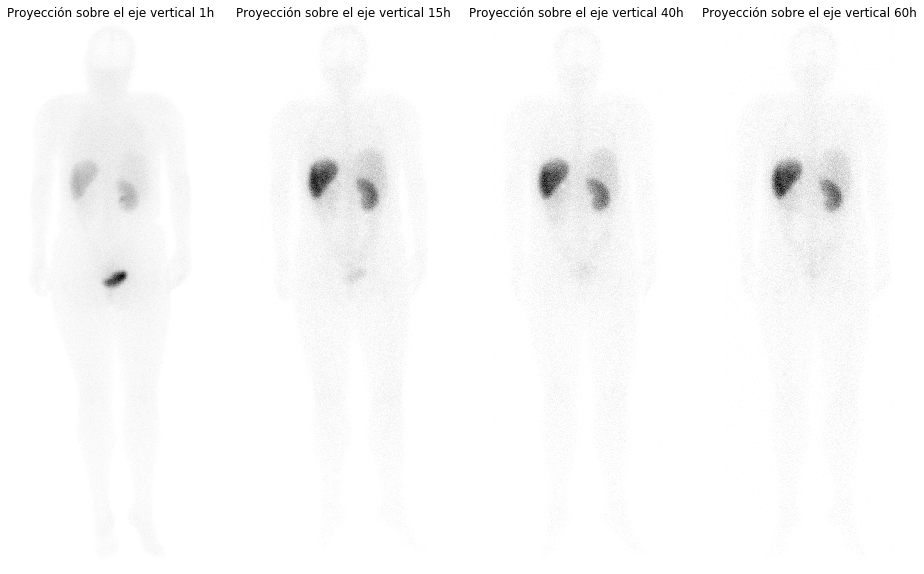

In [2]:
# Definimos el path en donde están las imágenes:
BASE='./Imágenes Pedro'
path_1hr = (BASE + '/1h')
path_15hr = (BASE +'/15h')
path_40hr = (BASE +'/40h')
path_64hr = (BASE +'/64h')

# Enlistamos y ordenamos los archivos dicom de cada carpeta
imgs_1hr = os.listdir(path_1hr)
imgs_15hr = os.listdir(path_15hr)
imgs_40hr = os.listdir(path_40hr)
imgs_64hr = os.listdir(path_64hr)

imgs_1hr.sort()
imgs_15hr.sort()
imgs_40hr.sort()
imgs_64hr.sort()

# Cargamos las imágenes de cada tiempo (sólo se usan las post_sc.dcm (posteriores), que nos parecieron las mejores):
img1_dcm =  dicom.read_file(path_1hr + '/' + imgs_1hr[2])
img1 = img1_dcm.pixel_array
img2_dcm =  dicom.read_file(path_15hr + '/' + imgs_15hr[2])
img2 = img2_dcm.pixel_array
img3_dcm =  dicom.read_file(path_40hr + '/' + imgs_40hr[2])
img3 = img3_dcm.pixel_array
img4_dcm =  dicom.read_file(path_64hr + '/' + imgs_64hr[2])
img4 = img4_dcm.pixel_array

# Graficamos las imágenes, recortadas para minimizar falta de registración:
img1 = img1[75:860,:]
img2 = img2[80:865,:]
img3 = img3[100:885,:]
img4 = img4[100:885,:]

# Buscamos el máximo para normalizar las cuentas a través de los tiempos (ver la atenuación que se produce)
# Se genera un vector con el máximo de cada imagen en cada elemento:
imax = [np.max(img1),np.max(img2),np.max(img3),np.max(img4)]
imin = [np.min(img1),np.min(img2),np.min(img3),np.min(img4)]

# Se grafican las imágenes:
fig, ax = plt.subplots(1,4,figsize=(16,10))
ax[0].set_title('Proyección sobre el eje vertical 1h')
ax[0].imshow(imax[0]-img1, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].set_title('Proyección sobre el eje vertical 15h')
ax[1].imshow(imax[1]-img2, cmap=plt.cm.gray)
ax[1].axis('off')
ax[2].set_title('Proyección sobre el eje vertical 40h')
ax[2].imshow(imax[2]-img3, cmap=plt.cm.gray)
ax[2].axis('off')
ax[3].set_title('Proyección sobre el eje vertical 60h')
ax[3].imshow(imax[3]-img4, cmap=plt.cm.gray)
ax[3].axis('off')
plt.show()

# Separamos la imagen en 5 categorías constituyentes: Fondo, Cuerpo, Órgano 1, Órgano 2, Vejiga.
fondo = img1.copy()
cuerpo = img1.copy()
organos = img1.copy()
vejiga = img1.copy()
fondo[fondo<7] = 1  
fondo[fondo>=7] = 0
cuerpo[cuerpo<7] = 0
cuerpo[cuerpo>75] = 0
cuerpo[cuerpo!=0] = 1
organos[organos<75] = 0
organos[organos>=75] = 1
vejiga = organos.copy()
organo1 = organos.copy()
organo2 = organos.copy()
organo1[300:,:] = 0
organo1[:,120:] = 0
organo2[300:,:] = 0
organo2[:,0:120] = 0
vejiga[0:300,:] = 0

# Para dejar regiones más 'simples' (sin bordes ruidosos) segmentadas, se realizan operaciones de cierre y apertura. 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fondo = cv2.morphologyEx(fondo, cv2.MORPH_OPEN, kernel)
organo1 = cv2.morphologyEx(organo1, cv2.MORPH_OPEN, kernel)
organo2 = cv2.morphologyEx(organo2, cv2.MORPH_OPEN, kernel)
cuerpo = cv2.morphologyEx(cuerpo, cv2.MORPH_CLOSE, kernel)
vejiga = cv2.morphologyEx(vejiga, cv2.MORPH_OPEN, kernel)

# Creamos máscaras lógicas de cada región
labels = cuerpo.copy()*1;
labels[organo1>0] = 2;
labels[organo2>0] = 3;
labels[vejiga>0] = 4;

In [3]:
# Se transformaron las imágenes a un pandas Data Frame
s = np.shape(img1)                  # Generamos un vector de longitud igual al largo de la imagen (número de filas), 
a = np.asarray(np.arange(0,s[0],1)) # cuyos elementos van de cero al número de filas
a = np.matlib.repmat(a,s[1],1)      # repetimos el vector a lo largo de las columnas, es decir tengo que cada 
                                    # elemento contiene el número de fila que posee
a = np.transpose(a)                 
y = a.flatten()                     # lo llevo a un vector, que tiene los números de fila de cada elemento

b = np.asarray(np.arange(0,s[1],1)) # Igual al caso anterior pero con las columnas
b = np.matlib.repmat(b,s[0],1)
x = b.flatten()

label_flat=labels.flatten()       # Un vector con la etiqueta ed cada elemento
int1_flat=img1.flatten()          # Un vector por intensidad en cada tiempo
int2_flat=img2.flatten()
int3_flat=img3.flatten()
int4_flat=img4.flatten()
l=np.shape(int1_flat)
tiempo=np.zeros(l[0])
tiempo1=tiempo+1                  # Vector de ceros que luego va a tener cada uno de los 4 tiempos
tiempo2=tiempo+15
tiempo3=tiempo+40
tiempo4=tiempo+60

# Definimos un primer juego de Data Frames por imágen:
Dosis_1=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_1['x']=x
Dosis_1['y']=y
Dosis_1['Intensidad']=int1_flat
Dosis_1['Etiqueta']=label_flat
Dosis_1['Tiempo']=tiempo1
Dosis_2=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_2['x']=x
Dosis_2['y']=y
Dosis_2['Intensidad']=int2_flat
Dosis_2['Etiqueta']=label_flat
Dosis_2['Tiempo']=tiempo2
Dosis_3=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_3['x']=x
Dosis_3['y']=y
Dosis_3['Intensidad']=int3_flat
Dosis_3['Etiqueta']=label_flat
Dosis_3['Tiempo']=tiempo3
Dosis_4=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_4['x']=x
Dosis_4['y']=y
Dosis_4['Intensidad']=int4_flat
Dosis_4['Etiqueta']=label_flat
Dosis_4['Tiempo']=tiempo4

# Diccionario para llevar las labels de números a strings
d={0: 'fondo',1: 'cuerpo',2: 'organo1',3: 'organo2',4: 'vejiga'}

#Concatenamos los Data Frames
frames = [Dosis_1,Dosis_2,Dosis_3,Dosis_4]
Dosis = pd.concat(frames)
Dosis = Dosis.replace({"Etiqueta": d})

#Guardamos el DataFrame o lo cargamos:
#Dosis.to_pickle('Dosis_database_tp2')

## GaussianMixture

#### Para comenzar, se trabaja con la imagen correspondiete a la hora de inyectado el radiofármaco y se buscan los clusters presentes. Se decide optar por el algoritmo de Expectation Maximization, que a su vez inicializa las medias por medio de k-means.

Se toman para cada pixel las coordenadas x,y y intensidad como features, así se puede evaluar la información de intensidad al mismo tiempo que la información espacial. 

In [5]:
X = Dosis.loc[(Dosis.Tiempo==1),'x':'Intensidad'].values  # Selección de datos (x,y,intensidad) de la imagen 1h

Se calcula el bayesian information criterion para decidir el mejor número de clusters que hay en la imagen (ya que no tenemos un número a priori)


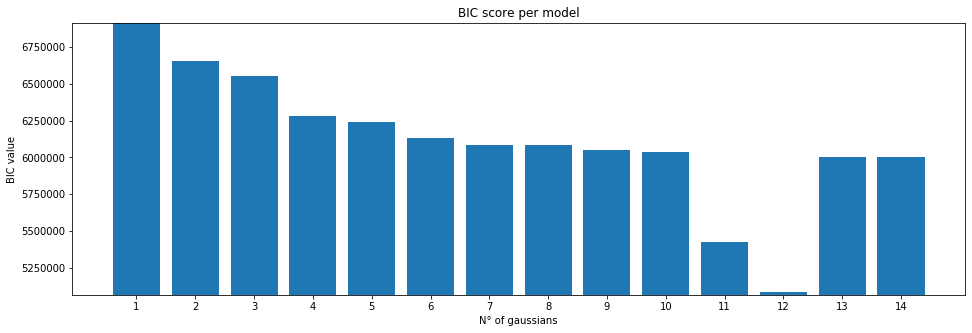

In [6]:
lowest_bic = np.infty               # El mejor inicialmente es un valor muy alto
bic = []                            # Contendrá los BIC por n° de clusters
n_components_range = range(1, 15)   # Número de Clusters
for n_components in n_components_range:
    gmm = mixture.GaussianMixture(n_components = n_components,  # Se instancia una mezcla de gaussianas 
                                  covariance_type = 'full',     # Se permite ajustar tanto medias como matriz de 
                                  max_iter=100,                 # covarianza 
                                  init_params='kmeans',         # Inicialización de medias con kmeans
                                  random_state=0)
    gmm.fit(X)                                                  # Se fitea el modelo con los datos
    bic.append(gmm.bic(X))                                      # Se calcula el bic y se guarda en la lista.
    if bic[-1] < lowest_bic:                                    # Si es mejor que el más bajo:
        lowest_bic = bic[-1]                                    # Se reemplaza
        best_gmm = gmm
bic = np.array(bic)
# Plot the BIC scores
plt.figure(figsize=(16, 5))
plt.bar(x=n_components_range, height=bic)
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
plt.ylabel('BIC value')
plt.xlabel('N° of gaussians')
plt.show()

De acuerdo a Bayesian Information Criterion, deberíamos elegir un modelo con 12 gaussianas:

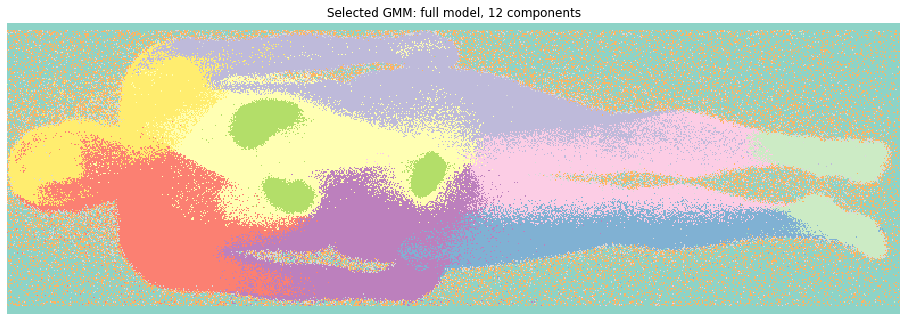

In [7]:
Y = best_gmm.predict(X)           # Con el mejor modelo según BIC, se predicen los clusters
labels = np.reshape(Y,s)          #  Se transforman los resultados en una imagen
plt.figure(figsize=(16,12))       # Se gafica
plt.imshow(np.transpose(labels),cmap=plt.get_cmap('Set3'))
plt.title('Selected GMM: full model, 12 components')
plt.axis('off')
plt.show()

Vemos que si bien identifica regiones en forma correcta, se generan más clusters de los que podríamos pensar que son necesarios. Ejemplo de esto son las regiones violeta, púrpura, amarillo, rojo. 

Se prueba con menos clusters. Si vemos el gráfico de bic, hay un cambio brusco en el valor desde 3 a 4 clusters y a continuación se mantiene más o menos constante hasta 11 clusters. Por esto probamos con 4:

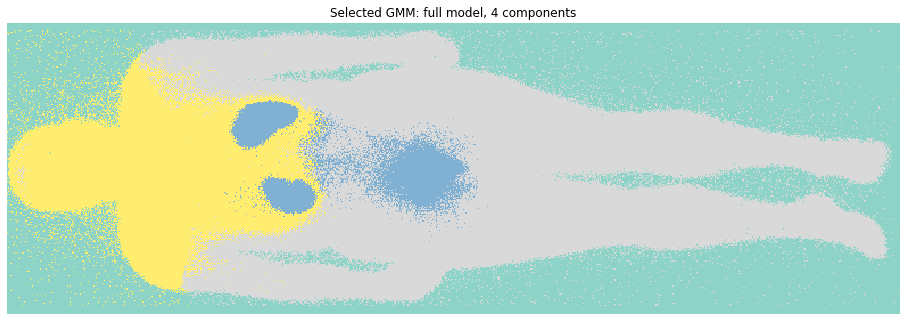

In [8]:
clust = mixture.GaussianMixture(n_components=4,covariance_type = 'full', 
                              init_params='kmeans',random_state=0)
Y = clust.fit_predict(X)
labels = np.reshape(Y,s)          #  Se transforman los resultados en una imagen
# Plot the winner
plt.figure(figsize=(16,12))       # Se gafica
plt.imshow(np.transpose(labels),cmap=plt.get_cmap('Set3'))
plt.title('Selected GMM: full model, 4 components')
plt.axis('off')
plt.show()

Se pude ver cómo la imagen generada es mucho más consecuente con la regiones identificadas en el trabajo práctico anterior. Hay pixels en el fondo que son identificados como cuerpo, lo que coincide con los outliers identificados en el trabajo anterior.

Luego la diferencia entre el cluster amarillo y gris, no había sido identificada, pero puede tener que ver con la influencia de los órganos (en conjunto con ese pequeño defecto de colimación) que hace que en los alrededores de éllos suba el nivel de intensidad y así se los identifique como un nuevo grupo.

Por último los órganos blanco del radiofármaco, son identificados en forma coincidente con lo hecho en el práctico anterior. La vejiga es identificada con dimensiones mayores.

#### Para mejorar los resultados se decide usar un abordaje mixto, se aprovechan las máscaras generadas en el trabajo previo y de aplica el algoritmo de mixtura de gaussianas a la porción de la imagen que NO se identificó como fondo.

In [9]:
cuerpo = (Dosis.Tiempo==1)&((Dosis.Etiqueta=='cuerpo')|   # Se genera un sub conjunto de los datos que contiene todos
                            (Dosis.Etiqueta=='organo1')|  # los pixeles dentro de "cuerpo"
                            (Dosis.Etiqueta=='organo2')|
                            (Dosis.Etiqueta=='vejiga'))
X = Dosis.loc[cuerpo,'x':'Intensidad'].values

Se repite lo realizado anteriormente con el bic:

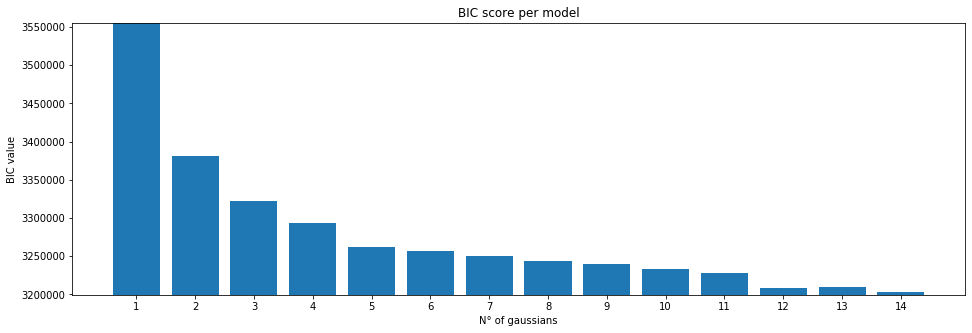

In [10]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
for n_components in n_components_range:
    gmm = mixture.GaussianMixture(n_components = n_components, covariance_type = 'full', 
                                  max_iter=100, init_params='kmeans', random_state=0)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
bic = np.array(bic)
# Plot the BIC scores
plt.figure(figsize=(16, 5))
plt.bar(x=n_components_range, height=bic)
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
plt.ylabel('BIC value')
plt.xlabel('N° of gaussians')
plt.show()

Se prueba con los 14 clusters sugeridos por BIC, pero el resultado es (como se esperaba) una sobredivición del cuerpo del paciente. Se decide seguir el mismo criterio aplicado antes y usar 2 clusters.

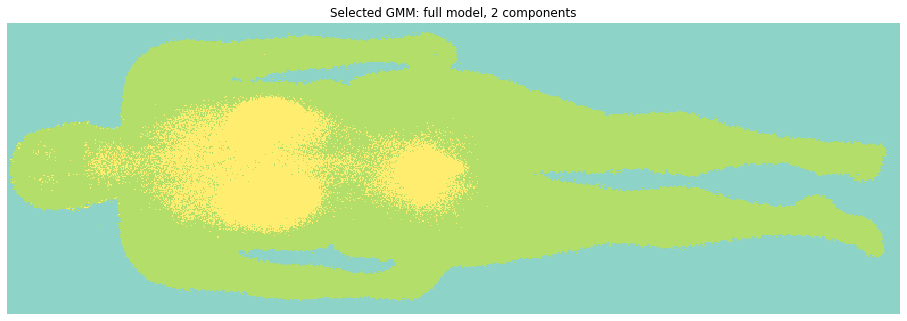

In [11]:
clust = mixture.GaussianMixture(n_components=2, covariance_type = 'full', 
                              init_params='kmeans', random_state=0)
indes = Dosis.loc[((Dosis.Tiempo==1)&((Dosis.Etiqueta=='cuerpo')|   # Se genera un sub conjunto de los datos que contiene todos
                            (Dosis.Etiqueta=='organo1')|  # los pixeles dentro de "cuerpo"
                            (Dosis.Etiqueta=='organo2')|
                            (Dosis.Etiqueta=='vejiga')))].index
Y = clust.fit_predict(X)
Y = Y+1
labels = np.zeros((s[0],s[1]))
dt = Dosis.loc[(Dosis.Tiempo==1),'x':'y']
dt['Label'] = 0
dt.loc[indes,'Label'] = Y
labels = dt.loc[:,'Label'].values
labels = np.reshape(labels,s)             #  Se transforman los resultados en una imagen
# Plot the winner
plt.figure(figsize=(16,12))               # Se gafica
plt.imshow(np.transpose(labels),cmap=plt.get_cmap('Set3'))
plt.title('Selected GMM: full model, 2 components')
plt.axis('off')
plt.show()

El resultado obtenido es muy interesante. Permite identificar una región central no separable a simple vista, que justamente coincide con aquella en el trabajo previo logramos por medio de los outliers en las imágenes de tiempos posteriores identificar regiones muy similares, en donde pareceieran tener presencia los pulmones los uréteres, la columna vertebral.

Se decide por quedarnos con esa porcion de los datos y volver a aplicar el algoritmo.

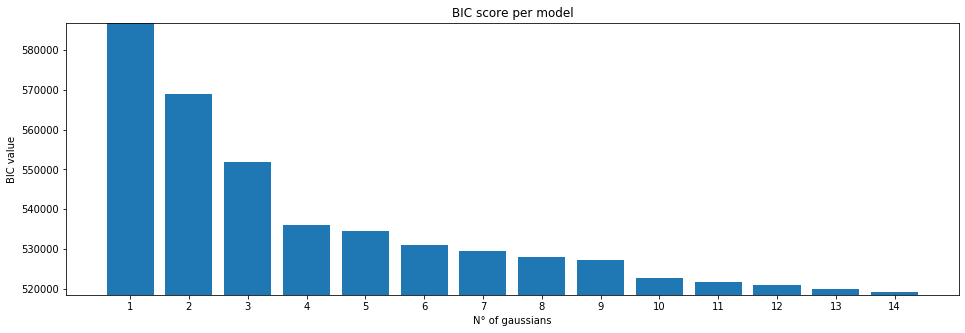

In [12]:
X2 = X[Y==2,:]
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
for n_components in n_components_range:
    gmm = mixture.GaussianMixture(n_components = n_components,covariance_type = 'full', 
                                  max_iter=100,init_params='kmeans',random_state=0)
    gmm.fit(X2)
    bic.append(gmm.bic(X2))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
bic = np.array(bic)
# Plot the BIC scores
plt.figure(figsize=(16, 5))
plt.bar(x=n_components_range, height=bic)
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
plt.ylabel('BIC value')
plt.xlabel('N° of gaussians')
plt.show()

Nuevamente se elige el punto de mayor salto en el bic, 4 gaussianas.

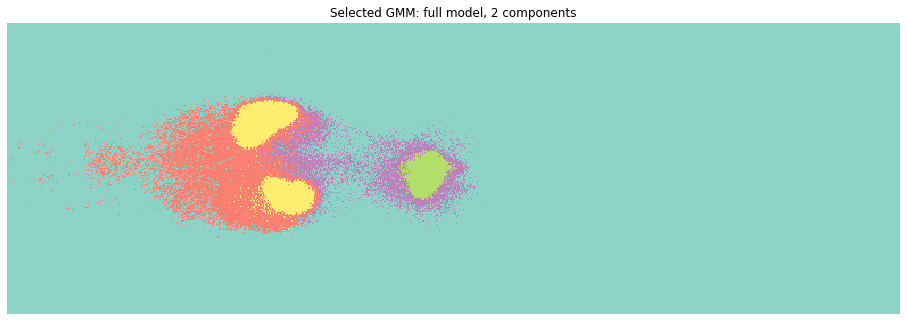

In [13]:
clust = mixture.GaussianMixture(n_components=4,covariance_type = 'full', 
                                init_params='kmeans',random_state=0)
indes = dt.loc[dt.Label==2,'Label'].index
Y2 = clust.fit_predict(X2)
Y2 = Y2+1
labels = np.zeros((s[0],s[1]))
dt2 = Dosis.loc[(Dosis.Tiempo==1),'x':'y']
dt2['Label'] = 0
dt2.loc[indes,'Label'] = Y2
labels = dt2.loc[:,'Label'].values
labels = np.reshape(labels,s)             #  Se transforman los resultados en una imagen
# Plot the winner
plt.figure(figsize=(16,12))               # Se gafica
plt.imshow(np.transpose(labels),cmap=plt.get_cmap('Set3'))
plt.title('Selected GMM: full model, 2 components')
plt.axis('off')
plt.show()

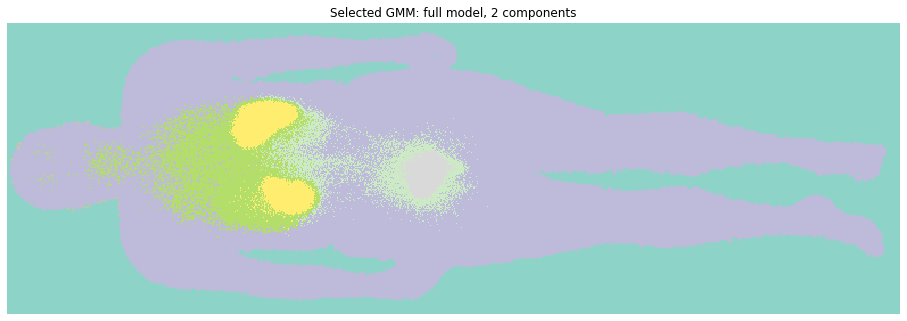

In [14]:
Y3 = dt.loc[:,'Label'].values+dt2.loc[:,'Label'].values
labels = np.zeros((s[0],s[1]))
labels = np.reshape(Y3,s)             #  Se transforman los resultados en una imagen
# Plot the winner
plt.figure(figsize=(16,12))               # Se gafica
plt.imshow(np.transpose(labels),cmap=plt.get_cmap('Set3'))
plt.title('Selected GMM: full model, 2 components')
plt.axis('off')
plt.show()

En la imagen se logra apreciar, cómo el algoritmo logra identificar los dos órganos como el mismo cluster (consecuente con nuestro trabajo previo), la vejiga como un elemento distinto, y finalmente todo un grupo de pixeles que se podrían corresponder con el tejido periférico a los órganos que emite con una intersidad mayor a la del resto del cuerpo, pero que no es el blanco concreto del radiofármaco.

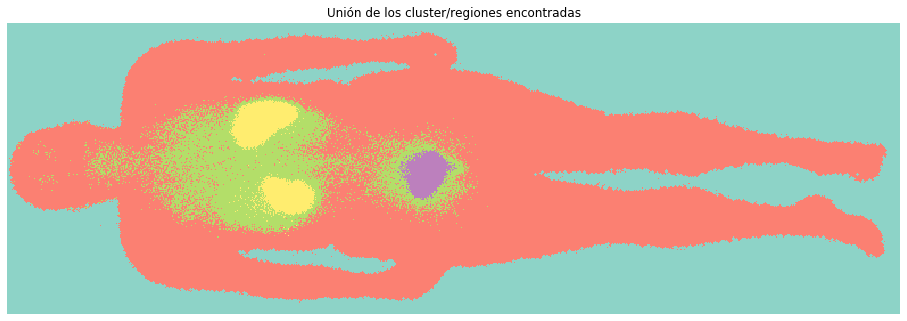

In [15]:
Y3 = dt.loc[:,'Label'].values+dt2.loc[:,'Label'].values
labels = np.zeros((s[0],s[1]))
for i in range(Y3.size):
    if (Y3[i]==5)|(Y3[i]==3):
        Y3[i]=2
    elif Y3[i]==4:
        Y3[i]=3
    elif Y3[i]==6:
        Y3[i]=4
labels = np.reshape(Y3,s)                 #  Se transforman los resultados en una imagen
# Plot the winner
plt.figure(figsize=(16,12))               # Se gafica
plt.imshow(np.transpose(labels),cmap=plt.get_cmap('Set3'))
plt.title('Unión de los cluster/regiones encontradas')
plt.axis('off')
plt.show()

### Se repite el mismo procedimiento realizado hasta acá con las imagenes correspondientes a los siguientes tiempos. Por razones de presentación, sólo se presentan las imágenes con el número de clusters más adecuado encontrado.

### Para la imagen a las 15 horas.

In [16]:
def image_clustering(img,Dosis,time,n):
    
    # Clustering con la totalidad de la imagen:
    s = np.shape(img)               # Generamos un vector de longitud igual al largo de la imagen (número de filas), 
    X = Dosis.loc[(Dosis.Tiempo==time),'x':'Intensidad'].values  # Selección de datos (x,y,intensidad) de la imagen 1h
    clust = mixture.GaussianMixture(n_components=4,covariance_type = 'full', 
                                  init_params='kmeans',random_state=0)
    Y = clust.fit_predict(X)
    labels = np.reshape(Y,s)          #  Se transforman los resultados en una imagen
    # Plot the winner
    fig, ax = plt.subplots(1,4,figsize=(20,18))       # Se gafica
    ax[0].imshow(labels,cmap=plt.get_cmap('Set3'))
    ax[0].set_title('Cuatro gaussianas todos los pixels')
    ax[0].axis('off')
    
    #Clustering sólo en la región "cuerpo"
    cuerpo = (Dosis.Tiempo==time)&((Dosis.Etiqueta=='cuerpo')| # Se genera un sub conjunto de los datos 
                                  (Dosis.Etiqueta=='organo1')| # que contiene todos los pixeles dentro de "cuerpo"
                                  (Dosis.Etiqueta=='organo2')|
                                  (Dosis.Etiqueta=='vejiga'))
    X = Dosis.loc[cuerpo,'x':'Intensidad'].values
    clust = mixture.GaussianMixture(n_components=2, covariance_type = 'full', 
                                  init_params='kmeans', random_state=0)
    indes = Dosis.loc[((Dosis.Tiempo==time)&((Dosis.Etiqueta=='cuerpo')|   # Se genera un sub conjunto de los datos 
                                (Dosis.Etiqueta=='organo1')|  # que contiene todos los pixeles dentro de "cuerpo"
                                (Dosis.Etiqueta=='organo2')|
                                (Dosis.Etiqueta=='vejiga')))].index
    Y = clust.fit_predict(X)
    Y = Y+1
    labels = np.zeros((s[0],s[1]))
    dt = Dosis.loc[(Dosis.Tiempo==1),'x':'y']
    dt['Label'] = 0
    dt.loc[indes,'Label'] = Y
    labels = dt.loc[:,'Label'].values
    labels = np.reshape(labels,s)             #  Se transforman los resultados en una imagen
    # Plot
    ax[1].imshow(labels,cmap=plt.get_cmap('Set3'))
    ax[1].set_title('Dos gaussianas en "cuerpo"')
    ax[1].axis('off')
    
    #Clustering en la región encontrada:
    
    X2 = X[Y==2,:]
    clust = mixture.GaussianMixture(n_components=n,covariance_type = 'full', 
                                    init_params='kmeans',random_state=0)
    indes = dt.loc[dt.Label==2,'Label'].index
    Y2 = clust.fit_predict(X2)
    Y2 = Y2+1
    labels = np.zeros((s[0],s[1]))
    dt2 = Dosis.loc[(Dosis.Tiempo==1),'x':'y']
    dt2['Label'] = 0
    dt2.loc[indes,'Label'] = Y2
    labels = dt2.loc[:,'Label'].values
    labels = np.reshape(labels,s)             #  Se transforman los resultados en una imagen
    # Plot
    ax[2].imshow(labels,cmap=plt.get_cmap('Set3'))
    ax[2].set_title('Dos gaussianas en la nueva región identificada')
    ax[2].axis('off')
    
    #Grafico completo con los subclusters encontrados:
    Y3 = dt.loc[:,'Label'].values+dt2.loc[:,'Label'].values
    labels = np.zeros((s[0],s[1]))
    labels = np.reshape(Y3,s)                 #  Se transforman los resultados en una imagen
    if time==1:
        for i in range(Y3.size):
            if Y3[i]>=3:
                Y3[i]=Y3[i]-1               
    # Plot
    ax[3].imshow(labels,cmap=plt.get_cmap('Set3'))
    ax[3].set_title('Unión de los cluster/regiones encontradas')
    ax[3].axis('off')
    
    plt.show()
    return labels

Primero se muestra un resumen de los resultados obtenidos previamente, a una hora de administrado el radiofármaco.

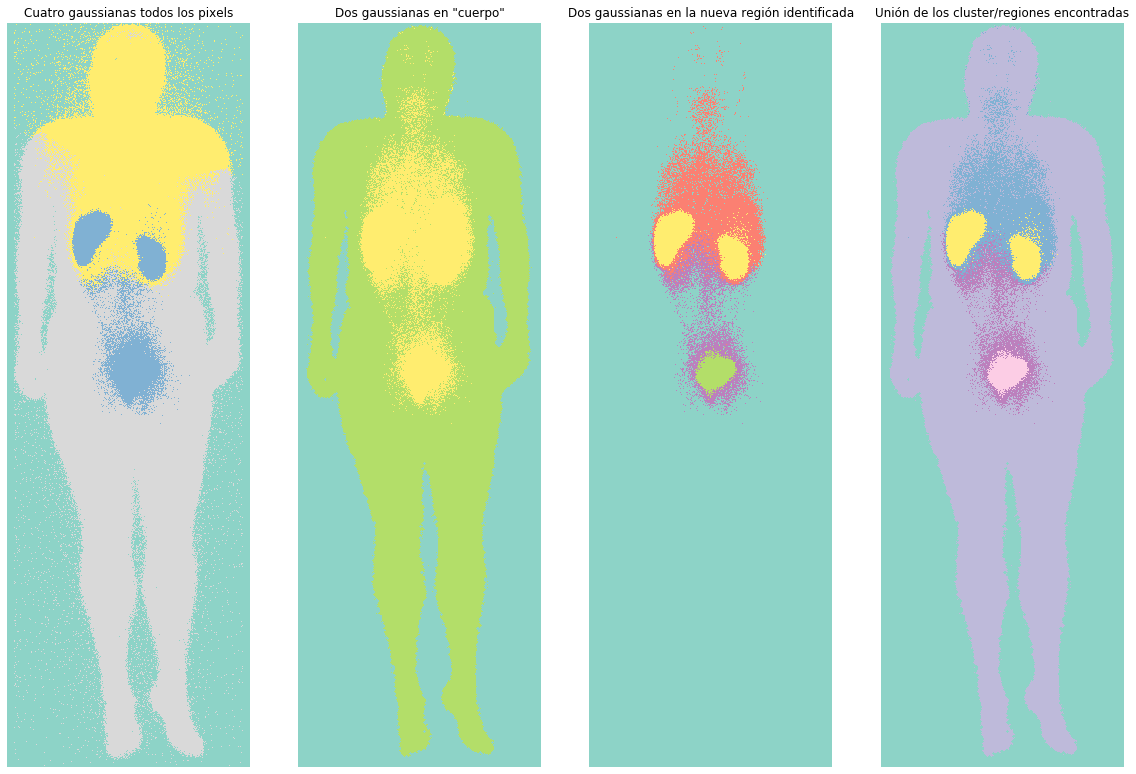

In [40]:
labels = np.empty((785,256,4))
labels[...,0] = image_clustering(img1,Dosis,1,4)

Luego a 15h de administrado el radiofármaco. Aquí se puede ver que la vejiga ya no es identificada como un clúster individual como en el caso anterior y que al usar la máscara de cuerpo la región no perteneciente a los órganos (amarillo) es identificada en forma homogenea.

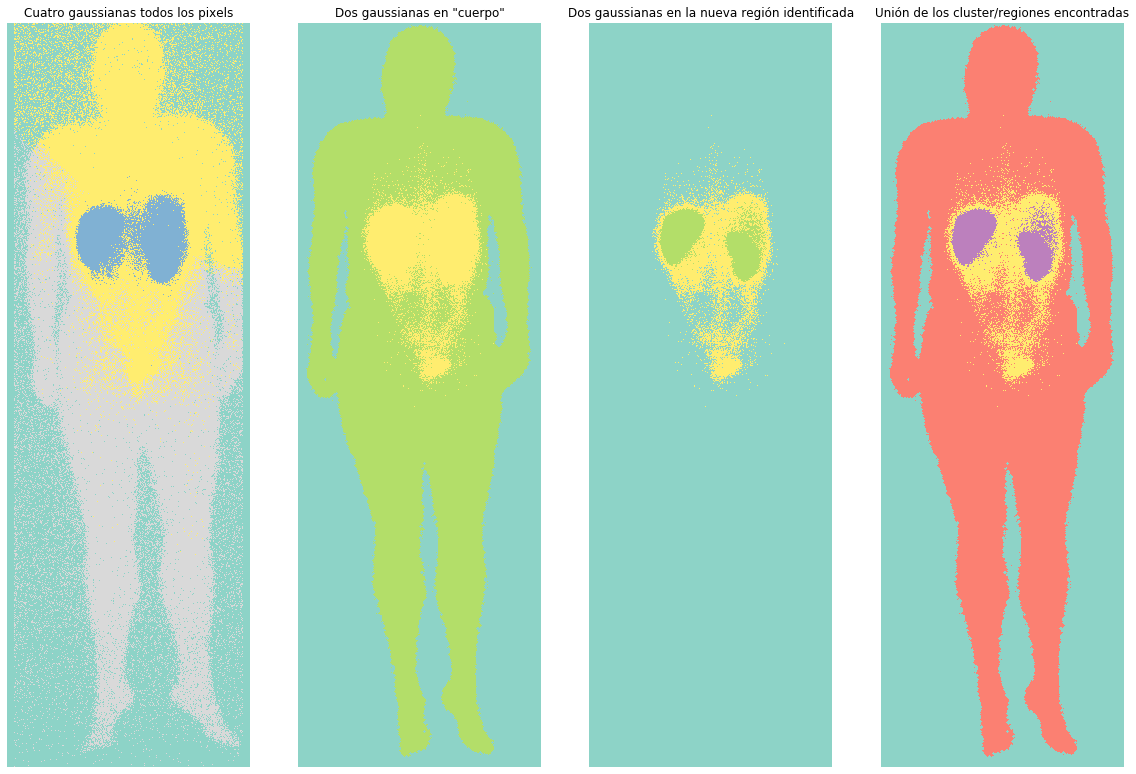

In [41]:
labels[...,1] = image_clustering(img2,Dosis,15,2)

Para la imagen correspondiente a 40 horas de administrado el radiofármaco se obtienen resultados similares a los comentados anteriormente.

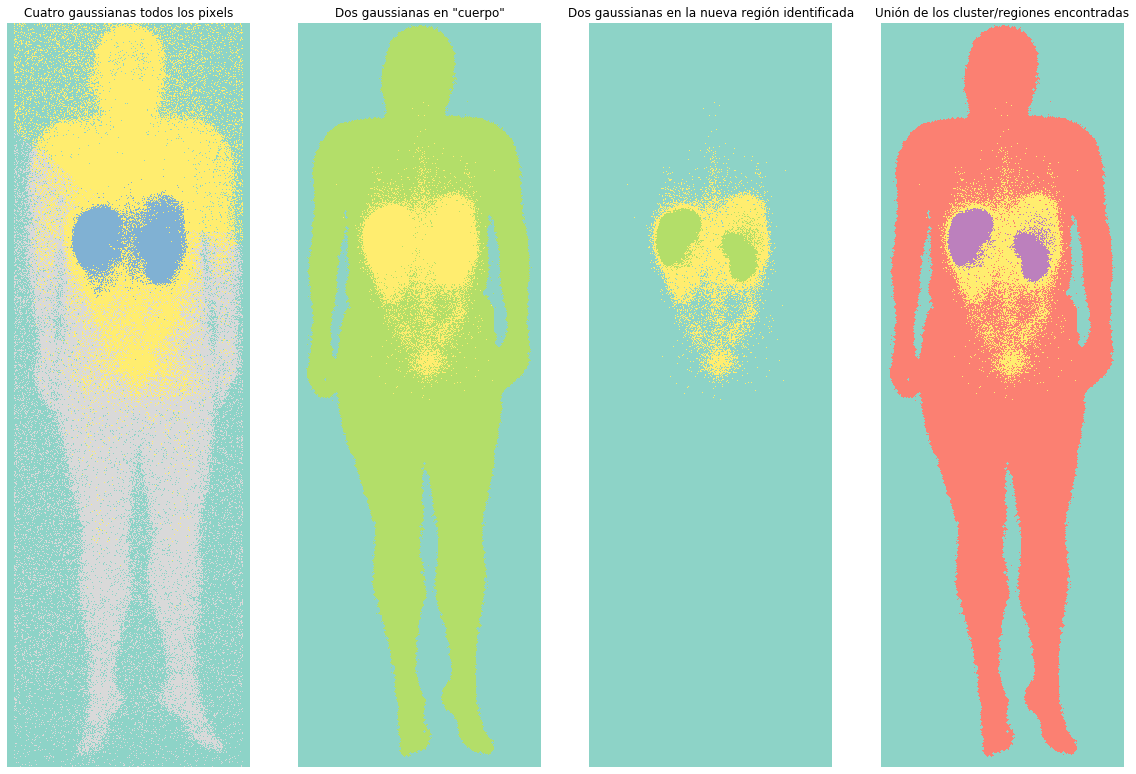

In [42]:
labels[...,2] = image_clustering(img3,Dosis,40,2)

En el caso de la imagen correspondiente a las 60 horas de administrado el radiofármaco, se puede ver que en el caso de no aplicar la máscara de cuerpo (primera imagen de la izquierda) la región no correpondiente a los órganos es mucho más extensa lo que puede deberse a la disminución de la intensidad a valores ya homogeneos con el resto del cuerpo.

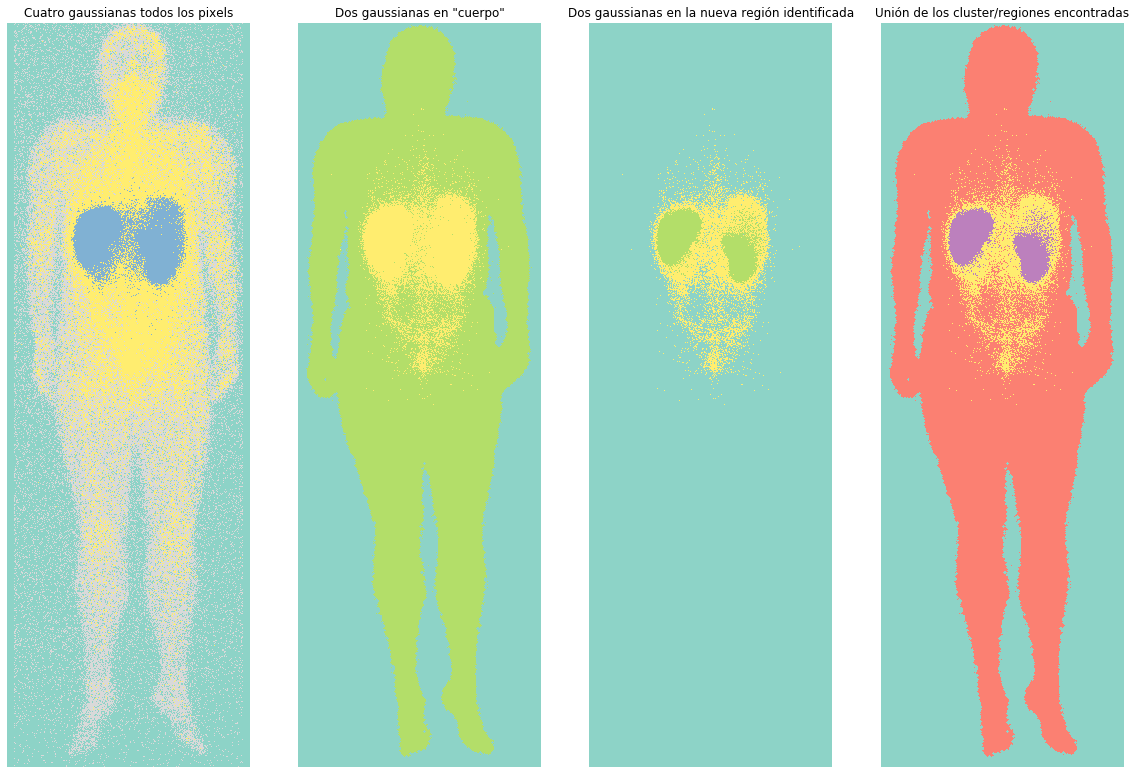

In [43]:
labels[...,3] = image_clustering(img3,Dosis,60,2)

### Resumen de los clusters identificados a partir de la estrategia mixta para cada uno de los tiempos:

Podemos ver que los órganos crecen de tamaño, desde la segunda imagen con respecto a la primera. También es interesante que se puede ver que hay una continuidad en las regiones identificadas.

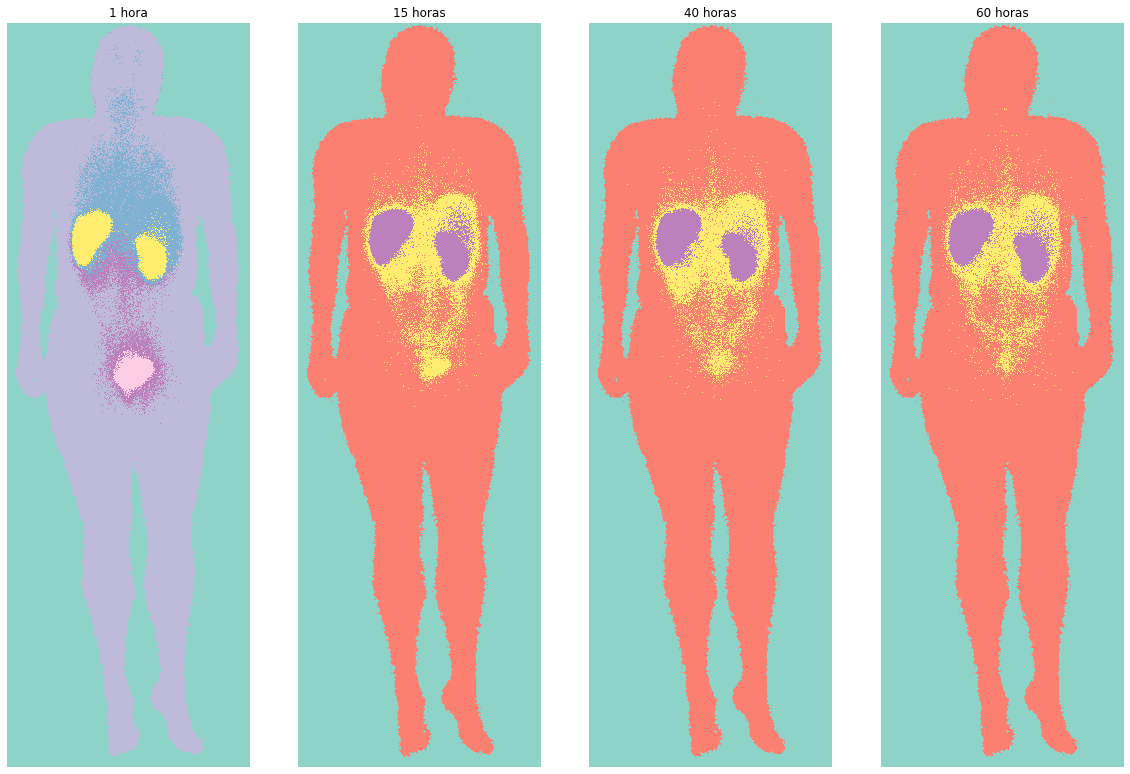

In [21]:
fig, ax = plt.subplots(1,4,figsize=(20,18))
times=['1 hora','15 horas','40 horas','60 horas']
for k,i in enumerate(times):
    ax[k].imshow(labels[...,k],cmap=plt.get_cmap('Set3'))
    ax[k].set_title(i)
    ax[k].axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,18))
times=['1 hora','15 horas','40 horas','60 horas']
for k,i in enumerate(times):
    ax[k].imshow(img1, cmap=plt.cm.gray)
    for l in range(n_clusters):
        plt.contour(labels[...,k] == l,colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
    ax[k].set_title(i)
    ax[k].axis('off')
plt.show()

In [71]:
Dosis['EtiquetaEM']= np.nan
Dosis['EtiquetaEM1h']= np.nan
Y = labels[...,0].flatten()
for i in range(Y.size):
    if Y[i]==4:
        Y[i]=2
labels[...,0] = np.reshape(Y,s)
for k,i in enumerate([1,15,40,60]):
    Dosis.loc[Dosis.Tiempo==i,'EtiquetaEM']=labels[:,:,k].flatten()
    Dosis.loc[Dosis.Tiempo==i,'EtiquetaEM1h']=labels[:,:,0].flatten()
Dosis.to_pickle('Dosis_database_tp2')

### Aglomerative Clustering

Después de probas varios números de clusters y evaluar los resultados, 7 clusters resulta más consecuente con lo que se intuye obetener de la imagen. 

Como criterio para determinar la unión jerárquica de clusters, se usa 'Ward'. Este minimiza la suma de las diferencias al cuadrado dentro de todos los grupos. 

In [18]:
def aglo_clust(img,n_clust,smooth=True):
    if smooth==True:
        img = gaussian_filter(img, sigma=2)
    s=img.shape
    X = np.reshape(img, (-1, 1))
    connectivity = grid_to_graph(*s) # Se genera la matriz de conectividad de los pixeles indicando las vecindades
    n_clusters = n_clust  # number of regions
    # Instanciación del modelo:
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity)
    ward.fit(X)
    label = np.reshape(ward.labels_, s)
    return label

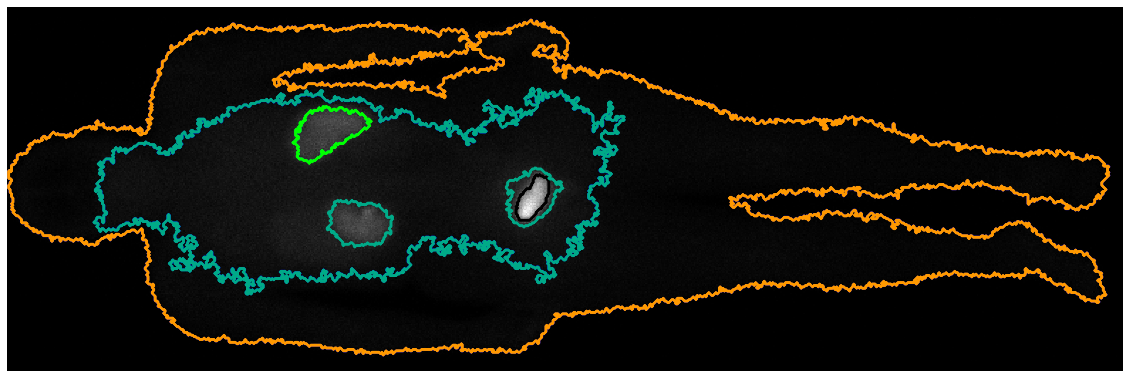

In [21]:
label = aglo_clust(img1,7,smooth=False)
# Plot the results on an image
plt.figure(figsize=(20, 12))
plt.imshow(np.transpose(img1), cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(np.transpose(label) == l,colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.axis('off')
plt.show()

Podemos ver que los clusters formados son consecuentes con lo obtenido tanto en el trabajo anterior como con mixtura de gaussianas. Quizás la segmentación de los brazos empeora, pero el contorno general del cuerpo se puede ver claramente.

En este caso resulta muy interesante ver la distinción de un sub grupo al rededor del tejido irradiado circundante a la vejiga, que podría ser de interés del profecional de la salud para ver los daños colaterales de la terapia.

Para evitar una división en regiones tan detallada (ruidosa) se realiza un suavizado previo de la imagen. Se reduce en uno el número de clusters, para simplificar las regiones consideradas considerando sus propiedades semánticas.

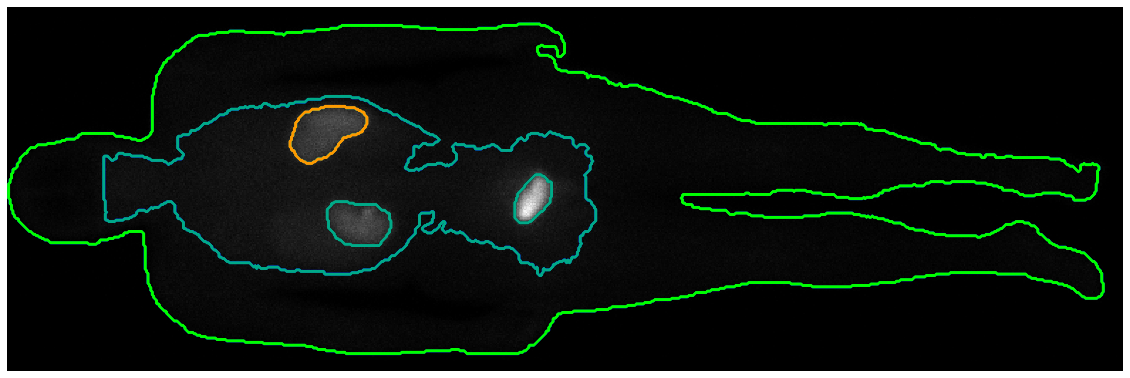

In [22]:
label = aglo_clust(img1,6)
# Plot the results on an image
plt.figure(figsize=(20, 12))
plt.imshow(np.transpose(img1), cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(np.transpose(label) == l,colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
plt.axis('off')
plt.show()

A continuación se generan representaciones similares para los demás tiempoos desde la administración del radiofármaco.

C:\Users\joaco\.conda\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.


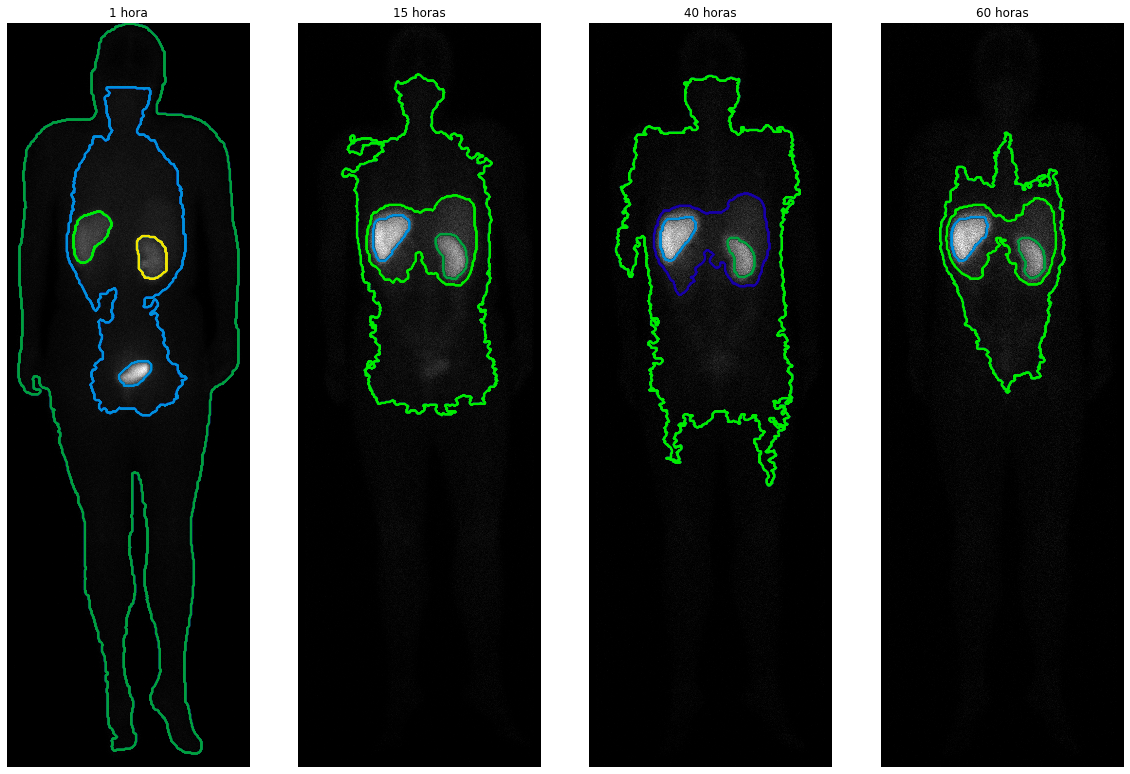

In [59]:
label = np.empty((785,256,4))
label[...,0] = aglo_clust(img1,6)
label[...,1] = aglo_clust(img2,5)
label[...,2] = aglo_clust(img3,5)
label[...,3] = aglo_clust(img4,5)

img = np.empty((785,256,4))
img[...,0] = img1
img[...,1] = img2
img[...,2] = img3
img[...,3] = img4


fig, ax = plt.subplots(1,4,figsize=(20,18))
times = ['1 hora','15 horas','40 horas','60 horas']
n_clusters = 7
for k,i in enumerate(times):
    ax[k].imshow(img[...,k], cmap=plt.cm.gray)
    for l in range(n_clusters):
        ax[k].contour(label[...,k] == l,colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
    ax[k].set_title(i)
    ax[k].axis('off')
plt.show()

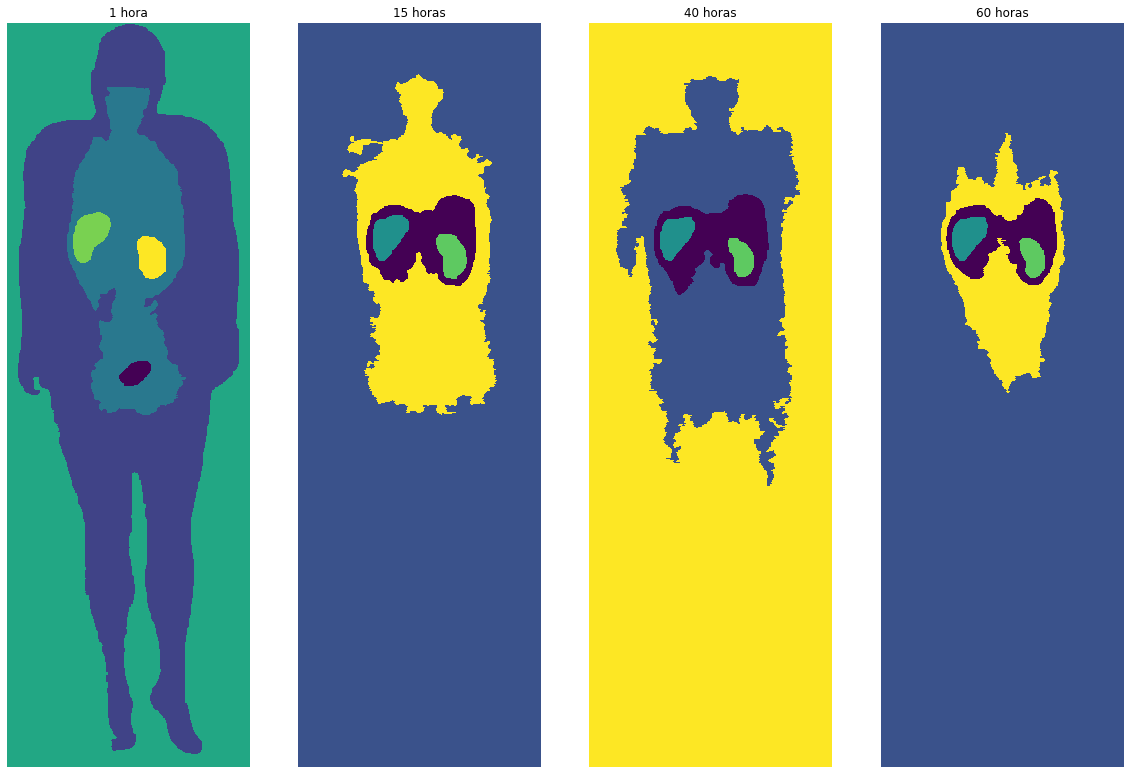

In [61]:
fig, ax = plt.subplots(1,4,figsize=(20,18))
times = ['1 hora','15 horas','40 horas','60 horas']
for k,i in enumerate(times):
    ax[k].imshow(label[...,k])
    ax[k].set_title(i)
    ax[k].axis('off')
plt.show()

## Centroides

Definimos basarnos en el clustering hecho sobre las imágenes del primer tiempo para obtener las máscaras de los distintas regiones. Con ellas, calcularemos los centroides en intensidad para todos los tiempos. Luego ploteamos para ver la curva de decaimiento obtenida.

# La parte de Mezcla de gaussianas se rompe porque yo modifiqué la salida de lo primero (porque lo puse para que se vieran como imágenes y otras cositas), al fondo está hecho, pero lo hice directo con el dataframe y sns, para que quede igual habría que separar un gráfico por etiqueta.

__Mixtura de Gaussianas:__

In [ ]:
print(np.unique(Y2_))
# 0 centro superior
# 1 vejiga
# 2 centro inferior
# 3 riñones

In [ ]:
# Obtenemos las máscaras lógicas
base = np.zeros(img1.T.shape)
base = base!=0
for pix in X2[Y2_ == 0, :2]:
    base[pix[0],pix[1]] = True
    centro_sup = base.T
    
base = np.zeros(img1.T.shape)
base = base!=0
for pix in X2[Y2_ == 2, :2]:
    base[pix[0],pix[1]] = True
    centro_inf = base.T
    
base = np.zeros(img1.T.shape)
base = base!=0
for pix in X2[Y2_ == 1, :2]:
    base[pix[0],pix[1]] = True
    vejiga = base.T
    
base = np.zeros(img1.T.shape)
base = base!=0
for pix in X2[Y2_ == 3, :2]:
    base[pix[0],pix[1]] = True
    riñones = base.T
    

mediasG = pd.DataFrame(columns=['Centro_Superior','Centro_Inferior','Vejiga','Riñones'])
rows=['1hs','15hs','40hs','64hs']
mascaras = (centro_sup,centro_inf,vejiga,riñones)

# Obtenemos la media de cada región para cada tiempo
for i,imagen in enumerate((img1,img2,img3,img4)):
    mediasG.loc[i] = [imagen[masc].mean() for masc in mascaras]
        
mediasG.index= rows
mediasG

Ploteamos las curvas de decaimiento

In [ ]:
plt.figure(figsize=(13, 6))
x=[1,15,40,64]

plt.subplot(2,2,1)
plt.plot(x, mediasG.Centro_Superior)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Centro_Superior')

plt.subplot(2,2,2)
plt.plot(x, mediasG.Centro_Inferior)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Centro_Inferior')

plt.subplot(2,2,3)
plt.plot(x, mediasG.Vejiga)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Vejiga')

plt.subplot(2,2,4)
plt.plot(x, mediasG.Riñones)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Riñones')

plt.tight_layout()
plt.show()

Se usaron los clusters encontrados por el algoritmo de mixtura de gaussianas. Ambos riñones fueron ubicados dentro del mismo cluster. Se plotean las curvas de decaimiento en el tiempo de la intensidad media de los centroides, y si bien éstas estan limitadas a las cuatro mediciones hechas, se observa que pueden corresponderse con el decaimiento exponencial que establece la física médica.

__Agglomerative Clustering:__

In [ ]:
print(np.unique(rescaled_label))
print(type(rescaled_label))

# 0: cuerpo
# 1: centro
# 2: interior vegiga 
# 3: fondo
# 4: riñon izquierda
# 5: borde vejiga 
# 6: riñon derecha 

In [ ]:
# Obtenemos las máscaras lógicas
mcuerpo = rescaled_label==0
mcentro = rescaled_label==1
mvejiga = numpy.logical_or(rescaled_label==2,rescaled_label==5)
mfondo = rescaled_label==3
mriñon_izquierda = rescaled_label==4
mriñon_derecha = rescaled_label==6

mediasA = pd.DataFrame(columns=['Fondo','Cuerpo','Centro','Vejiga','Riñon_izquierda','Riñon_derecha'])
rows=['1hs','15hs','40hs','64hs']
mascaras = (mfondo,mcuerpo,mcentro,mvejiga,mriñon_izquierda,mriñon_derecha)

# Obtenemos la media de cada región para cada tiempo
for i,imagen in enumerate((img1,img2,img3,img4)):
    mediasA.loc[i] = [imagen[masc].mean() for masc in mascaras]
        
mediasA.index= rows

In [ ]:
mediasA

Ploteamos las curvas de decaimiento

In [ ]:
plt.figure(figsize=(13, 6))
x=[1,15,40,64]

plt.subplot(2,2,1)
plt.plot(x, mediasA.Centro)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Centro')

plt.subplot(2,2,2)
plt.plot(x, mediasA.Vejiga)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Vejiga')

plt.subplot(2,2,3)
plt.plot(x, mediasA.Riñon_izquierda)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Riñon izquierda')

plt.subplot(2,2,4)
plt.plot(x, mediasA.Riñon_derecha)
plt.xlabel('Tiempo en horas')
plt.ylabel('Intensidad media')
plt.xticks(x, rows)
plt.title('Centroides-Riñon derecha')

plt.tight_layout()
plt.show()

### Para responder el punto 8, se calculan los centroides de cada cluster encontrado y se analiza su variación a lo largo del tiempo intentando ver la intensidad y cómo ésta sigue el patrón de decaimiento del radiofármaco.

In [52]:
Dosis['EtiquetaAC']= np.nan
Dosis['EtiquetaAC1h']= np.nan
for k,i in enumerate([1,15,40,60]):
    Dosis.loc[Dosis.Tiempo==i,'EtiquetaAC']=label[:,:,k].flatten()
    Dosis.loc[Dosis.Tiempo==i,'EtiquetaAC1h']=label[:,:,0].flatten()
Dosis.to_pickle('Dosis_database_tp2')

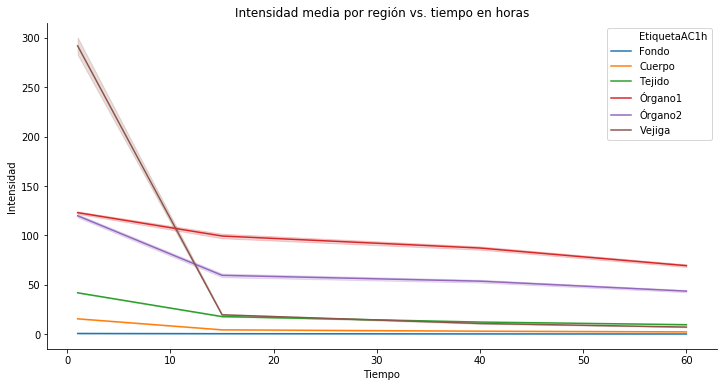

In [53]:
plt.figure(figsize=(12,6))
plt.title('Intensidad media por región vs. tiempo en horas')
nombre = {3:'Fondo',1:'Cuerpo',2:'Tejido',0:'Vejiga',4:'Órgano1',5:'Órgano2'}
Dosis =Dosis.replace({'EtiquetaAC1h': nombre})
# Dosis.EtiquetaEM1h = nombre[Dosis.EtiquetaEM1h]
sns.lineplot(x=Dosis.Tiempo, y=Dosis.Intensidad,hue=Dosis.EtiquetaAC1h, estimator='mean',ci=95,legend='full').get_lines()
sns.despine()
plt.show()

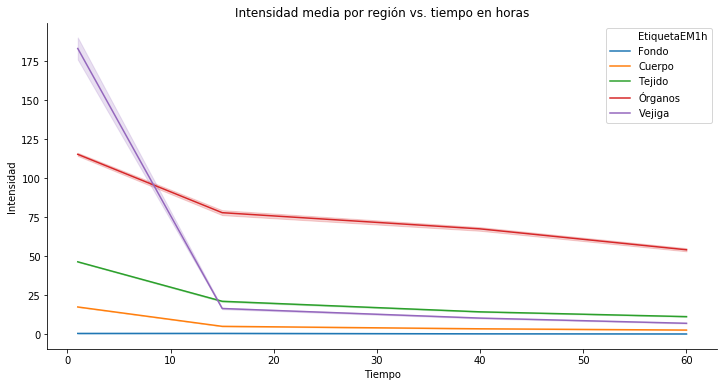

In [82]:
plt.figure(figsize=(12,6))
plt.title('Intensidad media por región vs. tiempo en horas')
nombre = {0:'Fondo',1:'Cuerpo',2:'Tejido',3:'Vejiga',5:'Órganos'}
Dosis =Dosis.replace({'EtiquetaEM1h': nombre})
# Dosis.EtiquetaEM1h = nombre[Dosis.EtiquetaEM1h]
sns.lineplot(x=Dosis.Tiempo, y=Dosis.Intensidad,hue=Dosis.EtiquetaEM1h, estimator='mean',ci=95,legend='full').get_lines()
sns.despine()
plt.show()